# Tai Project

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Imports

In [2]:
from fastai.basics import *
from fastai.vision import *

In [3]:
import librosa
import librosa.display

In [4]:
plt.style.use(['dark_background'])

In [5]:
DATA_PATH = Path.cwd()
MELTED = DATA_PATH/"taikkiso_phase2_melted.csv"
RAW = DATA_PATH/"taikkiso_phase2_raw.csv"

## Internal functions

In [9]:
#export
def root_mean_square(x):
    return np.sqrt(np.mean(x**2))

# Mean Absolute Deviation (Mean Absolute Value)
def mad(data, axis=None):
    return np.mean(np.absolute(data - np.mean(data, axis)), axis)

# Crest Factor
# https://en.wikipedia.org/wiki/Crest_factor
def crest_factor(x):
    # abs(peak)/RMS
    return np.max(np.abs(x))/np.sqrt(np.mean(x**2))

In [10]:
#export
def multiple_replace(string, rep_dict):
    pattern = re.compile("|".join([re.escape(k) for k in sorted(rep_dict,key=len,reverse=True)]), flags=re.DOTALL)
    return pattern.sub(lambda x: rep_dict[x.group(0)], string)

## Data Preparation

### Framing Data

In [11]:
df = pd.read_csv(f"{DATA_PATH}/taikkiso_phase2_melted.csv", engine='c')

In [12]:
df_raw  = pd.read_csv(RAW, engine='c')

In [13]:
df_raw.head()

,timestamp,temperature,axis,sample_rate,g1,g2,g3,g4,g5,g6,...,g4089,g4090,g4091,g4092,g4093,g4094,g4095,g4096,position,class_label
0,2018-10-17 11:23:04,0.0,2,9423,1599,1599,1599,1599,1599,1599,...,1597,1597,1598,1597,1598,1597,1598,1597,Left,1
1,2018-10-17 11:23:11,99.9,0,9422,1288,1288,1288,1286,1286,1284,...,1361,1362,1361,1360,1359,1360,1359,1360,Left,1
2,2018-10-17 11:23:16,0.0,1,9423,1275,1276,1276,1275,1276,1275,...,1324,1323,1325,1324,1324,1324,1324,1326,Left,1
3,2018-10-17 11:23:21,0.0,2,9419,1599,1599,1599,1599,1599,1599,...,1596,1597,1596,1597,1596,1596,1597,1596,Left,1
4,2018-10-17 11:25:00,99.9,0,9422,1281,1281,1279,1279,1278,1278,...,1361,1362,1362,1362,1361,1362,1363,1361,Left,1


In [14]:
for axis in df_raw.axis.unique():
    l,r = (len(df_raw[(df_raw.axis==axis) & (df_raw.position=='Left')]),
            len(df_raw[(df_raw.axis==axis) & (df_raw.position=='Right')]))
    print(f"Axis-{axis}: {l} {r}")

Axis-2: 576 446
Axis-0: 577 447
Axis-1: 578 448


FOR REAL?! The sensor data of x, y and z are a little bit shifted and the time-stamp is really confusing to to me. But let's accept it and earn the most from the data.

In [115]:
print(f"SR on-device : {df_raw.sample_rate.mean()} Hz ({(1/df_raw.sample_rate.mean())*1000} ms)")
print(f"SR on-laptop : 4096 Hz ({(1/4096)*1000} ms)")

SR on-device : 9421.42578125 Hz (0.10614104735507704 ms)
SR on-laptop : 4096 Hz (0.244140625 ms)


Noted: the original sampling rate on device is ~9KHz but the truth is the laptop recieved the resampled data at 4096 Hz.

What relieves me is that the `sample_rate` is 4096 on average, which is 0.244ms per sample, so even there is a time shift in data, I believe this issue is neglectable. 

In [116]:
#df_raw[df_raw.position=="Left"].class_label.value_counts().plot.barh()
#df_raw[df_raw.position=="Right"].class_label.value_counts().plot.barh()

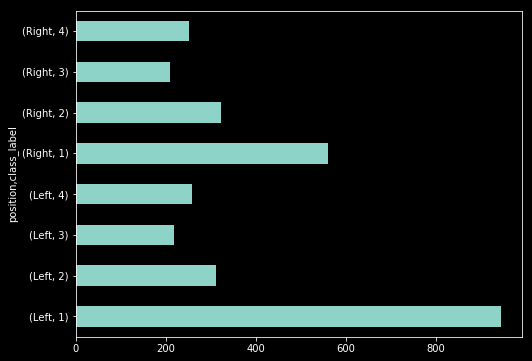

In [117]:
df_raw.groupby(["position", "class_label"]).count().g1.plot.barh(figsize=(8,6));

The labeled data is slightly imbalanced, I will see if I need to use `Focal Loss` later when training.

In [118]:
df_left, df_right = df_raw[df_raw.position=="Left"], df_raw[df_raw.position=="Right"]

In [119]:
len(df_left),len(df_right)

(1731, 1341)

In [16]:
lmin = min(len(df_left[df_left.axis==0]), len(df_left[df_left.axis==1]), len(df_left[df_left.axis==2]))
rmin = min(len(df_right[df_right.axis==0]), len(df_right[df_right.axis==1]), len(df_right[df_right.axis==2]))
lmin, rmin

(576, 446)

In [ ]:
for side,df,m in zip(["left", "right"], [df_left, df_right], [lmin, rmin]):
    sx,sy,sz = (df[df.axis==0][:m].iloc[:,4:-2].values,
                df[df.axis==1][:m].iloc[:,4:-2].values, 
                df[df.axis==2][:m].iloc[:,4:-2].values)
    # Use sx's timestamp for naming
    ts,lbs = df[df.axis==0][:m].timestamp.values, df[df.axis==0][:m].class_label.values
     
    for n_i in range(m):
        data = np.concatenate((sx[n_i][None,:], sy[n_i][None,:], sz[n_i][None,:]), axis=0).astype("float64")
        sid = [0,1][side=="left"]
        fname = multiple_replace(ts[n_i], {"-":"", " ": "_", ":":""})
        fname = DATA_PATH/f"ts/{side}/{fname}_{sid}_{lbs[n_i]}"
        #print(fname)
        Path(fname).parent.mkdir(exist_ok=True, parents=True)
        np.save(fname, data) 

### Streaming Data

I can use moving window with 50% overlap to retrieve more label data, or even I can use 50% overlap on normal label and 25% overlap on abnormal labeled data.
This data format is more alike in practice.

In [123]:
df_melt = pd.read_csv(MELTED, engine='c') 

In [11]:
df_melt.head()

,timestamp,class_label,axis,temperature,sample_rate,sample,value,position
0,2018-10-17T11:23:11Z,1,0,99.9,9422,g1,1288,L
1,2018-10-17T11:23:11Z,1,0,99.9,9422,g2,1288,L
2,2018-10-17T11:23:11Z,1,0,99.9,9422,g3,1288,L
3,2018-10-17T11:23:11Z,1,0,99.9,9422,g4,1286,L
4,2018-10-17T11:23:11Z,1,0,99.9,9422,g5,1286,L


In [12]:
df_left, df_right = df_melt[df_melt.position=="L"], df_melt[df_melt.position=="R"]

In [440]:
#export
def frame(ys, frame_length=1024, hop_length=512):
    res = None
    if type(ys) is not list: ys=[ys]
    for y in ys:
        #import pdb; pdb.set_trace()
        res = (librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length)[None,:] if res is None else
                np.vstack((res, librosa.util.frame(y, frame_length=frame_length, hop_length=hop_length)[None,:])))
        
    return res

In [441]:
#export
def framebylabel(df, label, frame_length=1024, hop_length=512):
    trunc = min([df[(df.axis==ax) & (df.class_label==label)].shape for ax in range(0,3)])[0]
    return frame([df[(df.axis==ax) & (df.class_label==label)][:trunc].value.values for ax in range(0,3)],
                                 frame_length, hop_length)

In [16]:
df_left.shape[0]/16896, df_right.shape[0]/16896*.8

(419.6363636363636, 260.07272727272726)

In [442]:
frame_length = 16896
for side,df in zip(["left", "right"], [df_left, df_right]):
    sid = [0,1][side=="left"]
    
    for label in range(1,5):
        if sid == 0: w = [.5,1][label==1]
        else:        w = [.3,1][label==1]
        
        # HACK
        xs = framebylabel(df, label=label, frame_length=frame_length, hop_length=int(frame_length*w))
        xs = np.moveaxis(xs, 2, 0)#; x.shape
        
        for idx,x in enumerate(xs):
            fname = DATA_PATH/f"tss/{side}/{idx:04d}_{sid}_{label}"
            #print(fname)
            Path(fname).parent.mkdir(exist_ok=True, parents=True)
            np.save(fname,x) 

### Labels

In [15]:
class_labels = df_raw.class_label.unique()
class_names = {
    1: "Normal",
    2: "Abnormal Bearing",
    3: "Abnormal Bushing",
    4: "Abnormal Bearing and Bushing"
}

## Data Preprocess

In [379]:
TEST_PATH = random.choice(random.choice((DATA_PATH/"tss").ls()).ls())
print(TEST_PATH)
tt = np.load(TEST_PATH)

/home/jupyter/workspace/exosite/murano_analytics_service/murano/taikkiso/austin/tss/left/0046_1_1.npy


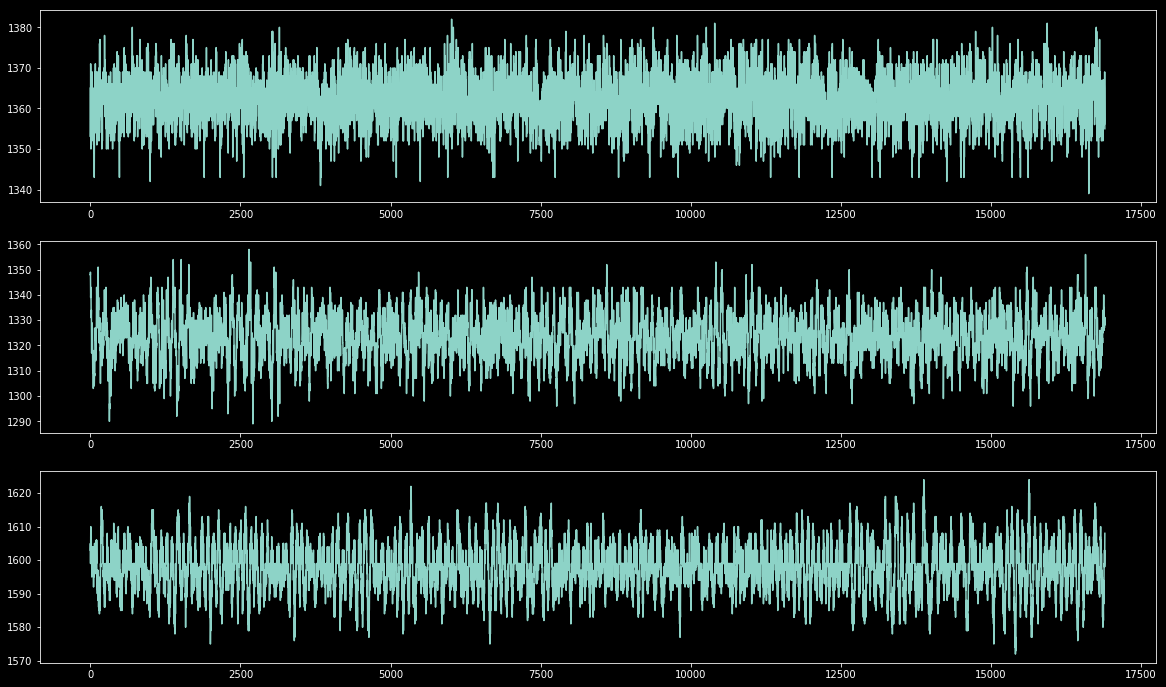

In [380]:
for i,ax in plot_flat(3,1,figsize=(20,12)):
    ax.plot(tt[i])

### Spectrogram 

A spectrogram is a visual representation of the distribution of energy across frequencies and over time. The axes of spectrogram represent discrete time and frequency steps, and intensity represents the amount of power at each time-frequency point.

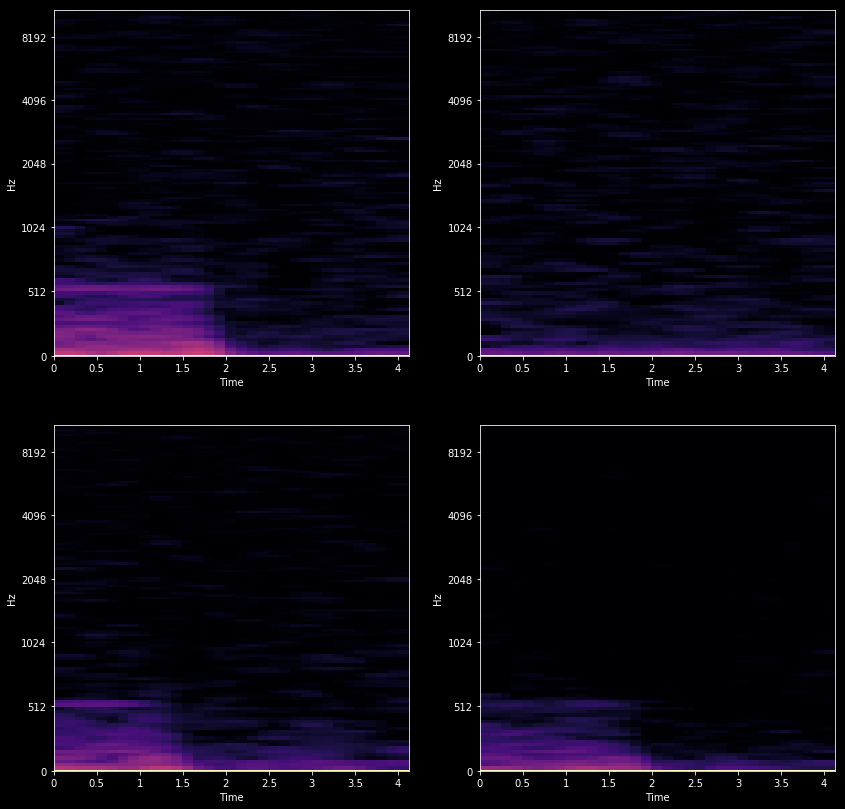

In [11]:
summ,sr = 0,4096
for i,ax in plot_flat(2,2,figsize=(14,14)):
    if i<=2:
        ts = tt[i]
        summ += ts**2
    else: ts = summ ** (1/2)
    S = librosa.feature.melspectrogram(y=ts, sr=sr, n_fft=1024, hop_length=128)
    log_S = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', ax=ax)

In [335]:
sr=4096
def ts2spectrogram(fname,i):
    try:
        save = str(fname).replace("tss", "specs").replace('.npy', '.png')
        if Path(save).is_file() == False:
            y = np.load(fname)
            y = np.sum(y**2, axis=0) ** (1/2)
            S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=128)
            log_S = librosa.power_to_db(S, ref=np.max)
            librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_frame_on(False)
            Path(save).parent.mkdir(exist_ok=True, parents=True)
            # save a figure without rim
            plt.savefig(save, dpi=200, bbox_inches='tight',pad_inches=0)
            plt.close('all')
    except Exception as e:
        print(f"Error {fname} {e}")

fnames = list((DATA_PATH/'tss').glob('**/*.npy'))
parallel(ts2spectrogram, fnames)

In [23]:
#export
def create_col(y):
    assert y.shape == (1024,)

    # Create time-series window
    fft_window = librosa.filters.get_window('hann', N_FFT, fftbins=True)
    assert fft_window.shape == (1024,), fft_window.shape

    # Hann window
    y_windowed = fft_window * y
    assert y_windowed.shape == (1024,), y_windowed.shape

    # FFT
    fft_out = fft.fft(y_windowed, axis=0)[:513]
    assert fft_out.shape == (513,), fft_out.shape

    # Power spectrum
    S_pwr = np.abs(fft_out)**2

    assert S_pwr.shape == (513,)

    # Generation of Mel Filter Banks
    mel_basis = librosa.filters.mel(SR, n_fft=N_FFT, n_mels=N_MELS, htk=False)
    assert mel_basis.shape == (30, 513)

    # Apply Mel Filter Banks
    S_mel = np.dot(mel_basis, S_pwr)
    S_mel.astype(np.float32)
    assert S_mel.shape == (30,)

    return S_mel
                                                                                                                                    
def feature_extraction(y):
    assert y.shape == (1024, 32)

    S_mel = np.empty((30, 32), dtype=np.float32, order='C')
    for col_index in range(0, 32):
        S_mel[:, col_index] = create_col(y[:, col_index])

    # Scale according to reference power
    S_mel = S_mel / S_mel.max()
    # Convert to dB
    S_log_mel = librosa.power_to_db(S_mel, top_db=80.0)
    assert S_log_mel.shape == (30, 32)

    return S_log_mel

In [89]:
#SR = 16000
#N_FFT = 1024
#N_MELS = 30

In [444]:
def ts2spectrogram(fname,i):
    try:
        save = str(fname).replace("tss", "specs").replace('.npy', '.png')
        if Path(save).is_file() == False:
            y = np.load(fname)
            y = np.sum(y**2, axis=0) ** (1/2)
            frames = librosa.util.frame(y, frame_length=1024, hop_length=512) 
            #S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=128)
            nb_features = int(frames.shape[1] / 32)
            log_S = np.empty((nb_features, 30, 32), dtype=np.float32, order='C')
            for i in range(0, nb_features):
                frame = frames[:, 0+i:32+i]
                log_S[i] = feature_extraction(frame)
                
            #log_S = librosa.power_to_db(S, ref=np.max)
            librosa.display.specshow(log_S[0], sr=16896, x_axis='time', y_axis='mel')
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_frame_on(False)
            Path(save).parent.mkdir(exist_ok=True, parents=True)
            # save a figure without rim
            plt.savefig(save, dpi=200, bbox_inches='tight',pad_inches=0)
            plt.close('all')
    except Exception as e:
        print(f"Error {fname} {e}")

fnames = list((DATA_PATH/'tss').glob('**/*.npy'))
parallel(ts2spectrogram, fnames)

## Train

In [39]:
#export
class FocalLoss(nn.Module):
    def __init__(self,c:int,gamma:float=2.0,alpha:float=.25):
        super().__init__()
        self.c,self.gamma,self.alpha = c,gamma,alpha
        
    def get_weight(self,x,t):
        p = x.sigmoid()
        pt = p*t + (1-p)*(1-t)
        w = self.alpha*t + (1-self.alpha)*(1-t)
        #import ipdb; ipdb.set_trace()
        return w * (1-pt).pow(self.gamma)
         
    def get_onehot(self,t):
         return torch.eye(self.c)[t.detach()]
        
    def forward(self, input, target, reduction='mean', **kwargs):
        #import ipdb; ipdb.set_trace()
        target = self.get_onehot(target).cuda()
        input = input.cuda()
        
        assert target.size() == input.size()
        
        ws = self.get_weight(input,target).detach()
        #import ipdb; ipdb.set_trace()
        loss = F.binary_cross_entropy_with_logits(input,target,ws,reduction='none')
        
        return loss.mean() if reduction=='mean' else loss.mean(dim=1)
    
#class FocalLoss(nn.Module):
#    def __init__(self,c:int,gamma:float=2.0):
#        super().__init__()
#        self.c,self.gamma = c,gamma
#        
#    def get_onehot(self,t):
#         return torch.eye(self.c)[t.data]
#        
#    def forward(self, input, target):
#        # Inspired by the implementation of binary_cross_entropy_with_logits
#        target = self.get_onehot(target).cuda()
#        
#        if not (target.size() == input.size()):
#            raise ValueError("Target size ({}) must be the same as input size ({})".format(target.size(), input.size()))
#
#        max_val = (-input).clamp(min=0)
#        loss = input - input * target + max_val + ((-max_val).exp() + (-input - max_val).exp()).log()
#
#        # This formula gives us the log sigmoid of 1-p if y is 0 and of p if y is 1
#        invprobs = F.logsigmoid(-input * (target * 2 - 1))
#        loss = (invprobs * self.gamma).exp() * loss
#        
#        return loss.sum(dim=1).mean()

In [16]:
tfms = get_transforms(do_flip=False, flip_vert=False, max_rotate=0.0,
                      max_lighting=0.0, max_warp=0.0, p_affine=0.0)

In [18]:
pat = r"(\d*).png$"
src = (ImageItemList.from_folder(DATA_PATH/'spec')
       .random_split_by_pct(valid_pct=0.2)
       .label_from_re(pat=pat))

In [19]:
data = (src.transform(tfms=tfms, size=224)
        .databunch(bs=64)
        .normalize(imagenet_stats))

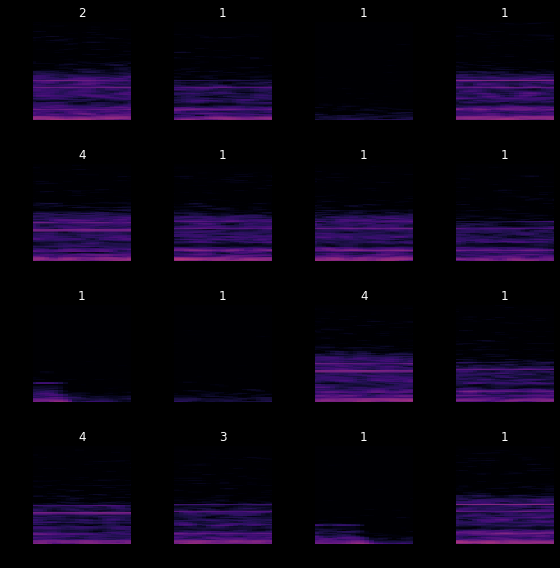

In [20]:
data.show_batch(rows=4, figsize=(8,8))

In [68]:
learn = None; gc.collect();
learn = create_cnn(data, models.resnet18, metrics=[error_rate], bn_final=True)

In [69]:
learn.loss_func = FocalLoss(data.c)

In [43]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.74E-01


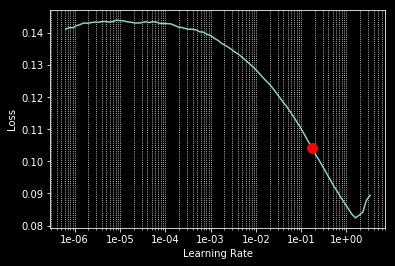

In [44]:
learn.recorder.plot()
plt.gca().grid(axis='x', which='both', linestyle=':')

In [45]:
#lr=2.51e-02
#lr=6.31e-03
lr=1.74E-01

In [70]:
learn.fit_one_cycle(18, lr)

epoch,train_loss,valid_loss,error_rate
1,0.098248,0.461462,0.504902
2,0.070059,0.791594,0.529412
3,0.049251,0.274158,0.509804
4,0.035287,0.015189,0.078431
5,0.026334,0.232892,0.436274
6,0.021348,0.504022,0.480392
7,0.017021,0.024725,0.063725
8,0.014284,0.076666,0.245098
9,0.011665,0.012902,0.058824
10,0.009559,0.007681,0.049020


In [47]:
learn.save("0-focal-res18-bn")

In [48]:
learn.load("0-focal-res18-bn");

In [49]:
learn.unfreeze()

In [50]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07


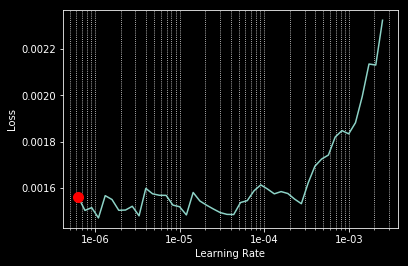

In [51]:
learn.recorder.plot()
plt.gca().grid(axis='x', which='both', linestyle=':')

In [52]:
learn.fit_one_cycle(10, max_lr=slice(2e-6,2e-4))

epoch,train_loss,valid_loss,error_rate
1,0.001589,0.001216,0.014706
2,0.001661,0.001278,0.014706
3,0.001588,0.001328,0.014706
4,0.001536,0.001337,0.014706
5,0.001527,0.001542,0.014706
6,0.001529,0.001656,0.014706
7,0.001495,0.001413,0.014706
8,0.001474,0.001380,0.014706
9,0.001413,0.001374,0.014706
10,0.001415,0.001384,0.014706


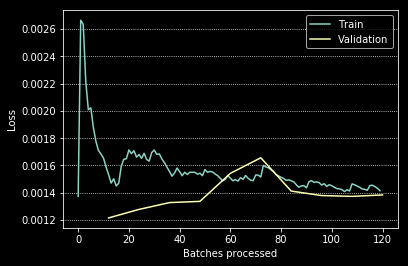

In [53]:
learn.recorder.plot_losses()
plt.gca().grid(axis='y', which='both', linestyle=':')

In [54]:
learn.save("1-focal-res18-bn")

In [55]:
interp = ClassificationInterpretation.from_learner(learn)

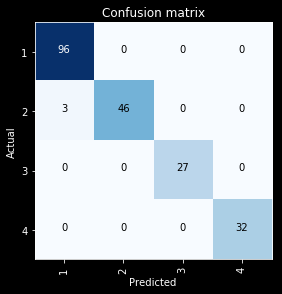

In [56]:
interp.plot_confusion_matrix()

### Recurrence

Reference
1. [Classification of Time-Series Images Using Deep Convolutional Neural Networks](https://arxiv.org/pdf/1710.00886.pdf)
2. [Imaging Time-Series to Improve Classification and Imputation](https://www.ijcai.org/Proceedings/15/Papers/553.pdf)
3. [Recurrence Plots of Dynamical Systems](http://www.ihes.fr/~/ruelle/PUBLICATIONS/%5B92%5D.pdf)

## Todos

- [x] Convert `df` to data size of (1, 4096, 3)
- [x] Mel-spectralize the time-series data
- [ ] Study other kind of 2D representation of ts data
    - [ ] RecurrencePlots: Recurrence Plot
    - [ ] GASF: Gramian Angular Summation Field
    - [ ] GADF: Gramian Angular Difference Field
    - [ ] MTF: Markov Transition Field
    ![](./ts_repr.jpg)
- [ ] [Do I really care about the x/y/z directions?](https://www.quora.com/Is-there-a-way-to-combine-a-3-axis-accelerometer-gyroscope-into-one-value)

## EON

In [19]:
SR = 16000
N_FFT = 1024
N_MELS = 30

In [20]:
wav_filename = Path.cwd()/"bus.wav"

In [21]:
# Load audio file as a floating point time series
y, _ = librosa.load(wav_filename, sr=SR, mono=True, dtype=np.float32)
#y = np.load(TEST_PATH)
# Slice into overlapping frames
frames = librosa.util.frame(y[:16896], frame_length=1024, hop_length=512)

In [28]:
nb_features = int(frames.shape[1] / 32)
S_log_mel = np.empty((nb_features, 30, 32), dtype=np.float32, order='C')                                                                                                                                             

for i in range(0, nb_features):
    frame = frames[:, 0 + i:32 + i]
    S_log_mel[i] = feature_extraction(frame)

AttributeError: 'function' object has no attribute 'fft'

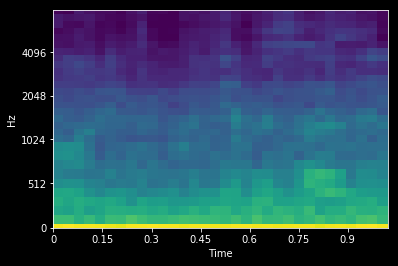

In [369]:
librosa.display.specshow(S_log_mel[0], sr=SR, y_axis='mel', fmax=8000,
                         x_axis='time', cmap='viridis')

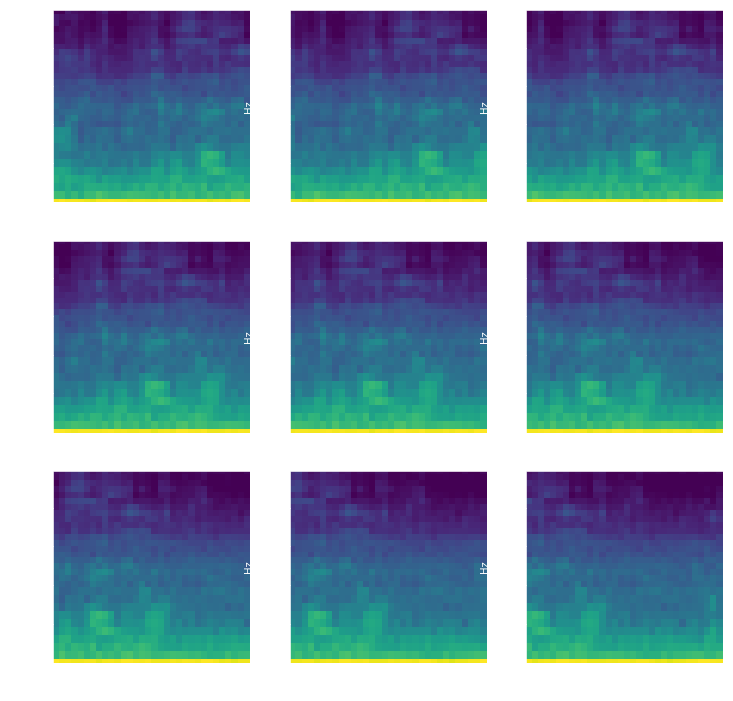

In [100]:
for i,ax in plot_flat(3,3,figsize=(12,12)):
    librosa.display.specshow(S_log_mel[i*3], sr=SR, y_axis='mel', fmax=8000,
                         x_axis='time', cmap='viridis', ax=ax)

In [348]:
#export
def create_col(y):
    assert y.shape == (1024,)

    # Create time-series window
    fft_window = librosa.filters.get_window('hann', N_FFT, fftbins=True)
    assert fft_window.shape == (1024,), fft_window.shape

    # Hann window
    y_windowed = fft_window * y
    assert y_windowed.shape == (1024,), y_windowed.shape

    # FFT
    fft_out = fft.fft(y_windowed, axis=0)[:513]
    assert fft_out.shape == (513,), fft_out.shape

    # Power spectrum
    S_pwr = np.abs(fft_out)**2

    assert S_pwr.shape == (513,)

    # Generation of Mel Filter Banks
    mel_basis = librosa.filters.mel(SR, n_fft=N_FFT, n_mels=N_MELS, htk=False)
    assert mel_basis.shape == (30, 513)

    # Apply Mel Filter Banks
    S_mel = np.dot(mel_basis, S_pwr)
    S_mel.astype(np.float32)
    assert S_mel.shape == (30,)

    return S_mel
                                                                                                                                    
def feature_extraction(y):
    assert y.shape == (1024, 32)

    S_mel = np.empty((30, 32), dtype=np.float32, order='C')
    for col_index in range(0, 32):
        S_mel[:, col_index] = create_col(y[:, col_index])

    # Scale according to reference power
    S_mel = S_mel / S_mel.max()
    # Convert to dB
    S_log_mel = librosa.power_to_db(S_mel, top_db=80.0)
    assert S_log_mel.shape == (30, 32)

    return S_log_mel

In [ ]:
# Extract features from overlapping frames (drop end-of-file samples)
# S_log_Mel[0] = first feature (30x32) matrix
# S_log_Mel[1] = second feature (30x32) matrix
# ...
nb_features = int(frames.shape[1] / 32)
S_log_mel = np.empty((nb_features, 30, 32), dtype=np.float32, order='C')
for i in range(0, nb_features):
    frame = frames[:, 0 + i:32 + i]
    S_log_mel[i] = feature_extraction(frame)

# Plot first feature/spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_log_mel[0], sr=SR, y_axis='mel', fmax=8000,
                         x_axis='time', cmap='viridis')
# plt.pcolormesh(S_log_Mel[0])
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

plt.show()

In [45]:
from pyts.image import GramianAngularField, MarkovTransitionField, RecurrencePlot
from pyts.preprocessing import StandardScaler

In [46]:
ts2image(tt[0])

TypeError: encode_img() got an unexpected keyword argument 'n_bins'

array([1270., 1272., 1273., 1273., ..., 1352., 1352., 1352., 1352.])

In [78]:
# Recurrence plots are a visualization tool for (multivariate) time-series.
# modified from https://stackoverflow.com/questions/33650371/recurrence-plot-in-python
def recurrence_matrix(s, eps=0.1, steps=10, metric="euclidean"):
    d = pairwise.pairwise_distances(s, metric=metric)
    d = np.floor(d / eps)
    d[d > steps] = steps
    # Z = squareform(d)
    return d

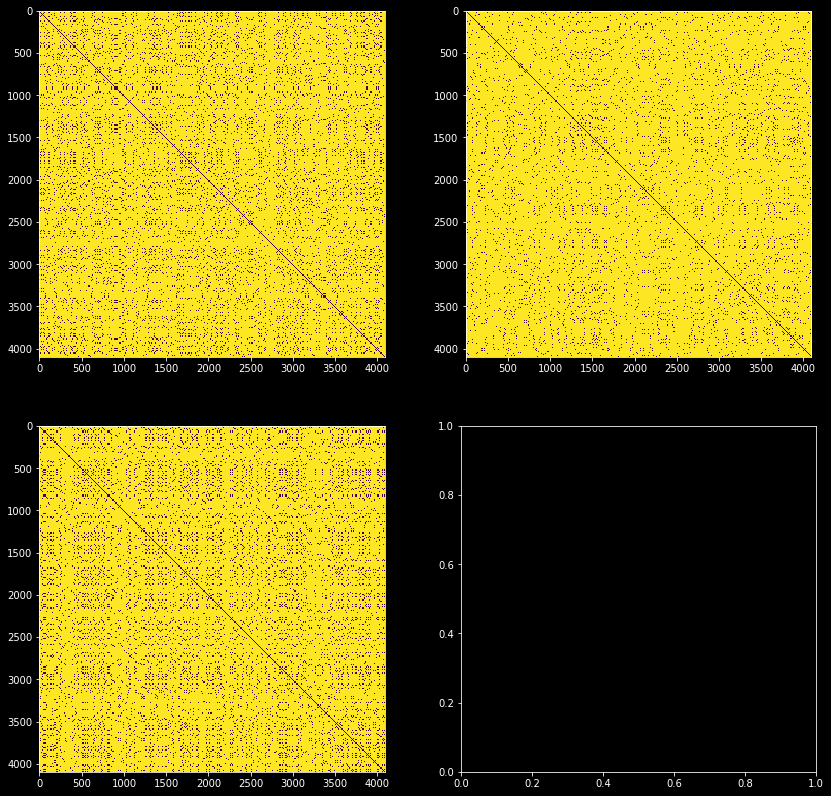

In [91]:
summ,sr = 0,4096
for i,ax in plot_flat(2,2,figsize=(14,14)):
    if i<=2: ax.imshow(recurrence_matrix(tt[i][:,None]))

In [55]:
str(TEST_PATH).replace()

PosixPath('/home/jupyter/workspace/exosite/murano_analytics_service/murano/taikkiso/austin/ts/left/20181017_120614_1_1.npy')

## Feature Extraction

In [ ]:
def root_mean_square(x):
    return np.sqrt(np.mean(x**2))

# Mean Absolute Deviation (Mean Absolute Value)
def mad(data, axis=None):
    return np.mean(np.absolute(data - np.mean(data, axis)), axis)

# Crest Factor
# https://en.wikipedia.org/wiki/Crest_factor
def crest_factor(x):
    # abs(peak)/RMS
    return np.max(np.abs(x))/np.sqrt(np.mean(x**2))

In [ ]:
from scipy.fftpack import fft, rfft
from scipy import signal
from scipy.signal import hilbert, welch
from scipy.stats import kurtosis, skew, iqr

In [ ]:
agg_func = {
    "value": [ root_mean_square,
              crest_factor,
              mad,
              np.min,
              np.max,
              np.median,
              np.mean,
              skew,
              kurtosis,
              np.std,
              iqr,
              # "count", not good
              "sum",
              np.var,
              np.cov,
    ]
}

In [ ]:
%%time
feature_df = df.groupby(["position", "timestamp", "axis", "class_label"]).agg(agg_func).reset_index(drop=False, col_level=0)

In [ ]:
feature_df

In [ ]:
feature_df.shape